In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn, Tensor

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import random
import math
import time

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../code/')
import util

import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


### Set the path and specification that you want to predict

In [47]:
data_path = '../data/transformer_data'
spec = 'airworthy' #'hover'#'interference'#'dist' #'mass' #'airworthy'
max_mass = 35. #(kg)

### Download the dataset and build the data loaders

In [48]:
torch.manual_seed(0)
np.random.seed(0)
batch_size = 2 # 512
batch_size_val = 2 # 512
frac_train = 0.4
frac_val = 0.4

dataloader_tr, dataloader_val, dataloader_test, scale_1, scale_2 = ssm.prepare_sequence_data(data_path, spec, batch_size = batch_size ,batch_size_val = batch_size_val, frac_train = frac_train, frac_val = frac_val)

In [243]:
dic = torch.load(data_path)
print(dic.keys())
# dic['X'][-1]
K = len(dic['encoding_dict_keys'])
V = len(dic['encoding_dict_values'])

dict_keys(['X', 'X_norm', 'y', 'airworthy', 'hover_time', 'max_speed', 'max_distance', 'interference_list', 'encoding_dict_keys', 'encoding_dict_values', 'norm_dict', 'path', 'folders'])


In [244]:
print(K, V)

43 577


In [241]:
def decode(dic, tokens, values):
    '''
    Take an encoding dictionary {'token0':0, 'token1':1, ... } and list of tokens [0, 1, 4, ... ]
    and return the corresponding strings of tokens ['token0', 'token1', 'token4', ...]
    '''
    
    seq = []
    dic_reverse = {value:key for key, value in dic.items()}
    for n, tok in enumerate(tokens):
        if dic_reverse[int(tok)] == 'Value':
            seq.append(float(values[n]))
        else:
            seq.append(dic_reverse[int(tok)])
    return seq
# decoded_design = []
# for i in range(len(int(dic['X'][-1]):
k = decode(dic['encoding_dict_keys'], dic['X'][-1][:,:K].argmax(1), None)
v = decode(dic['encoding_dict_values'], dic['X'][-1][:,K:K+V].argmax(1), dic['X_norm'][-1][:,-1])
    # decoded_design.append({k[0]:v[0]}

In [242]:
[{k[i]:v[i]} for i in range(len(k))]

[{'node_type': 'ConnectedHub6_2_2_2'},
 {'node_type': 'PropArm'},
 {'armLength': 1.273342490196228},
 {'motorType': 't_motor_U7_V2.0KV490'},
 {'propType': 'apc_propellers_17x10E'},
 {'offset': 1.05441415309906},
 {'angle': -0.34535443782806396},
 {'node_type': 'PropArm'},
 {'armLength': 1.2337090969085693},
 {'motorType': 't_motor_MN4010KV370'},
 {'propType': 'apc_propellers_15x5_5MR'},
 {'offset': 1.4664674997329712},
 {'angle': -0.34535443782806396},
 {'node_type': 'AngledPropArm'},
 {'armLength': -1.1449865102767944},
 {'motorType': 't_motor_AT4130KV300'},
 {'propType': 'apc_propellers_14x14N'},
 {'node_type': 'SingleBatteryFuselageWithComponents'},
 {'batteryType': 'TurnigyGraphene1300mAh4S75C'},
 {'length': -1.7053556442260742},
 {'vertDiameter': -1.1021184921264648},
 {'horzDiameter': -0.5969943404197693},
 {'floorHeight': -1.1021186113357544},
 {'batteryX': -3.175426721572876},
 {'batteryY': 0.0},
 {'rpmX': -3.6147842407226562},
 {'rpmY': 0.5969963669776917},
 {'autoPilotX': -3.

In [49]:
print(f'Training Data:   {dataloader_tr.dataset.y_train.shape[0]}')
print(f'Validation Data: {dataloader_val.dataset.y_train.shape[0]}')
print(f'Test Data:       {dataloader_test.dataset.y_train.shape[0]}')

Training Data:   6
Validation Data: 6
Test Data:       3


### Set up model from the seq_to_spec_model.py

In [188]:
torch.manual_seed(0)
np.random.seed(0)

emsize = 200  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 8  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 20  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
D_out = 200
D = dataloader_tr.dataset.x_train.shape[-1]



In [189]:
"""
class TransformerEncoder(nn.Module):
  def __init__(self, input_size, num_head, hidden_size, num_layers):

    super(TransformerEncoder, self).__init__()

    self.embd = nn.Embedding(word_count,input_size)
    encoder_layer = nn.TransformerEncoderLayer(input_size, num_head, hidden_size)
    self.transformer_enc = nn.TransformerEncoder(encoder_layer, num_layers)
    self.linear1 = nn.Linear(input_size,270)

def forward(self, x):
    x = x.long()
    emb = self.embd(x)
    mem = self.transformer_enc(emb)
    out = self.linear1(mem)
    return out, mem
"""

class TransformerModel(nn.Module):

    def __init__(self, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.01, D: int = 741,
                 emsize: int = 200): #dropout was 0.5
        super().__init__()
        
        self.D = D
        self.D_out = emsize
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(self.D, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, self.D_out)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
#         Need to permute from B x SL x D to SL x B x D
        src = self.encoder(src.permute(1, 0, 2)) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        mem = self.transformer_encoder(src, src_key_padding_mask=src_mask)# #Don't use a mask here, we want to predict over whole sequence, src_mask)
        output = self.decoder(mem)
        return output, mem

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1) 
    
class TransformerDecoder(nn.Module):
  def __init__(self, input_size, num_head, output_size, hidden_size, num_layers, dropout: float = 0.01):
    super(TransformerDecoder, self).__init__()

    decoder_layer = nn.TransformerDecoderLayer(input_size, num_head, hidden_size, dropout)
    self.transformer_dec = nn.TransformerDecoder(decoder_layer, num_layers)
    self.linear1 = nn.Linear(input_size, output_size)
      # nn.linear(inpute_size, K+V+1)

  def forward(self, x: Tensor, mem: Tensor, tgt_mask: Tensor = None)-> Tensor:
    out = self.transformer_dec(x, mem) #, tgt_key_padding_mask=tgt_mask)
    out = self.linear1(out)
    return out

class TransformerAutoencoder(nn.Module):
    def __init__(self, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.01, D: int = 741,
                 emsize: int = 200): 
        super().__init__()
        self.transformer_encoder = TransformerModel(d_model, nhead, d_hid, nlayers, dropout, D, emsize)
        self.transformer_decoder = TransformerDecoder(d_model, nhead, 653, d_hid, nlayers, dropout)
    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        out, mem = self.transformer_encoder(src, src_mask)
        print(out.size)
        print(mem.size)
        out  =self.transformer_decoder(out,mem)
        out = out.permute(1, 0, 2)
        return out

def loss(out):
    l1 = crossentropy_loss(out[:K],X_k) #K=19 X_k: input up to K
    l2 = crossentropy_loss(out[K:K+V],X_v)
    if X_v == 'Value':
        l3 = mse(out[-1], X_float)
    return l1 + l2 + l3

In [190]:
model = TransformerAutoencoder( emsize, nhead, d_hid, nlayers, dropout, D, D_out).to(device)

In [191]:
batch, train_data=next(enumerate(dataloader_tr))
data, targets, mask = train_data

In [192]:
data.size(), targets.size(), mask.size()

(torch.Size([2, 69, 653]), torch.Size([2]), torch.Size([2, 69]))

In [ ]:
X_k: data[:,:,:K] #19
X_v: datat[:,:,K:K+V] #V (above code)

In [193]:
output= model(data.to(device), mask.to(device))

<built-in method size of Tensor object at 0x7f9b15c26520>
<built-in method size of Tensor object at 0x7f9afb858090>


In [194]:
output.size()

torch.Size([2, 69, 653])

### Set up the training routine

In [180]:
import copy
import time

criterion = nn.MSELoss()
    
lr = .1  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = 0 #bptt
    for batch, train_data in enumerate(dataloader_tr):
        data, targets, mask = train_data
        output = model(data.to(device), mask.to(device))
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1

    return total_loss/num_batches

def evaluate(model: nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    num_batches = 0
    with torch.no_grad():
        for batch, val_data in enumerate(dataloader_val):
            data, targets, mask = val_data
            output = model(data.to(device), mask.to(device))
            loss = criterion(output, data)
            num_batches += 1
            total_loss += loss.item()
    return total_loss/num_batches

### Train the model and save the best according to the validation data

In [184]:
best_loss = float('inf')
epochs = 100 #300
best_model = None

loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    loss = train(model)
    val_loss = evaluate(model)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'loss {loss:5.4f} | ')
          #f'val loss {val_loss:5.4f}' )
    print('-' * 89)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
    loss_list.append(loss)
    val_loss_list.append(val_loss)
 

<built-in method size of Tensor object at 0x7f9afb85aa70>
<built-in method size of Tensor object at 0x7f9afb859850>
<built-in method size of Tensor object at 0x7f9b2e5a2700>
<built-in method size of Tensor object at 0x7f9afb847c90>
<built-in method size of Tensor object at 0x7f9af5bf0630>
<built-in method size of Tensor object at 0x7f9afb8471a0>
<built-in method size of Tensor object at 0x7f9afb85a7a0>
<built-in method size of Tensor object at 0x7f9afb8594e0>
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  5.09s | loss 0.0659 | 
-----------------------------------------------------------------------------------------
<built-in method size of Tensor object at 0x7f9afb1b7830>
<built-in method size of Tensor object at 0x7f9afb1b43b0>
<built-in method size of Tensor object at 0x7f9b0a9c9670>
<built-in method size of Tensor object at 0x7f9b0a9ab6f0>
<built-in method size of Tensor object at 0x7f9af5bf2f70>
<built-in metho

### Plot the training and validation loss

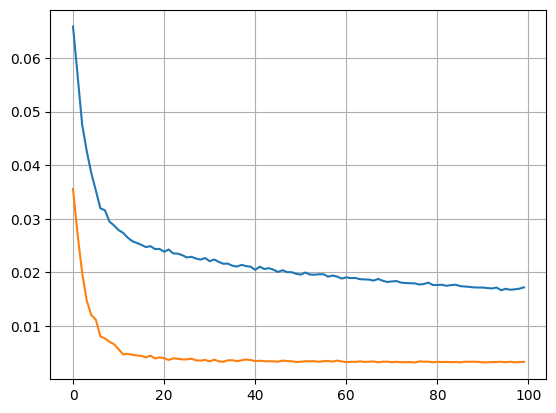

In [185]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_list)
plt.plot(val_loss_list)
plt.grid()
plt.show()

In [201]:
i = 0
for x,y,m in dataloader_test:
    with torch.no_grad():
        print(x.shape)
        best_model.eval().to(device)
        output = best_model(x.to(device), m.to(device)).cpu()
        print("MSE btw input and output of autoencoder",criterion(x, output).item())

torch.Size([3, 69, 653])
<built-in method size of Tensor object at 0x7f9b060ac4f0>
<built-in method size of Tensor object at 0x7f9b1139ffb0>
MSE btw input and output of autoencoder 0.004527577199041843
